In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from matplotlib import font_manager
import seaborn as sns
import matplotlib.patches as mpatches
import torch
from enum import Enum
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer

In [3]:
urlPtBr = 'https://raw.githubusercontent.com/CleissonVieira/fake-reviews-bert-ptbr/main/datasets/yelp-fake-reviews-dataset-pt.csv'
dfPtBr = pd.read_csv(urlPtBr)
dfPtBr = dfPtBr[['content', 'qtd_friends', 'qtd_reviews', 'qtd_photos', 'fake_review']]
dfReal = dfPtBr[dfPtBr.fake_review == False]
dfFake = dfPtBr[dfPtBr.fake_review == True]
df_balanceado_ptBr = pd.concat([dfReal.sample(n=3387, random_state=42), dfFake.sample(n=3387, random_state=42)])
df_balanceado_ptBr['fake_review'] = df_balanceado_ptBr['fake_review'].astype(int)

In [ ]:
TOKENIZADOR = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

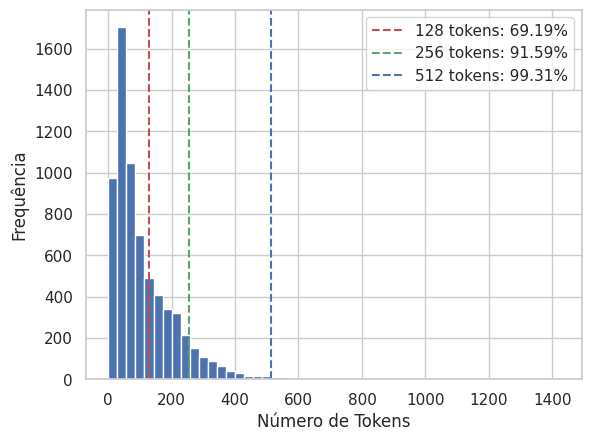

In [ ]:
# FREQUENCIA MAX_LENGHT
dfMaxLength = df_balanceado_ptBr
dfMaxLength['review_length'] = dfMaxLength['content'].apply(len)
dfMaxLength['num_tokens'] = dfMaxLength['content'].apply(lambda x: len(TOKENIZADOR.tokenize(x)))

total_reviews = len(dfMaxLength)
percent_128 = (dfMaxLength['num_tokens'] <= 128).sum() / total_reviews * 100
percent_256 = (dfMaxLength['num_tokens'] <= 256).sum() / total_reviews * 100
percent_512 = (dfMaxLength['num_tokens'] <= 512).sum() / total_reviews * 100

plt.hist(dfMaxLength['num_tokens'], bins=50)
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')

plt.axvline(128, color='r', linestyle='--', label=f'128 tokens: {percent_128:.2f}%')
plt.axvline(256, color='g', linestyle='--', label=f'256 tokens: {percent_256:.2f}%')
plt.axvline(512, color='b', linestyle='--', label=f'512 tokens: {percent_512:.2f}%')
plt.legend()

plt.show()

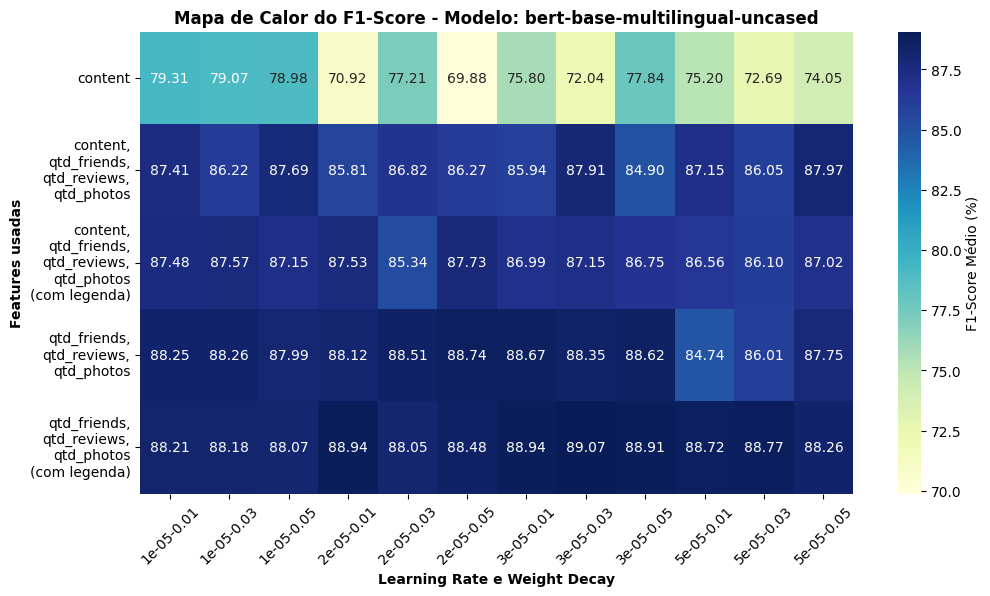

In [4]:
file_path = '/content/drive/My Drive/TCCII/_todasPossibilidadesModelosBert.csv'
df = pd.read_csv(file_path)
df_test = df[df['model'] == 'bert-base-multilingual-uncased']

for feature in df_test['model'].unique():
    df_feature = df_test[df_test['model'] == feature]

    pivot_table = df_feature.pivot_table(
        values='f1_score_mean',
        index=['features_used'],
        columns=['learning_rate', 'weight_decay'],
        aggfunc='mean'
    )

    pivot_table = pivot_table * 100

    # max_idx = np.unravel_index(np.nanargmax(pivot_table.values), pivot_table.shape)
    # best_row, best_col = pivot_table.index[max_idx[0]], pivot_table.columns[max_idx[1]]

    # sorted_index = sorted(pivot_table.index, key=lambda x: abs(pivot_table.index.get_loc(x) - pivot_table.index.get_loc(best_row)))
    # sorted_columns = sorted(pivot_table.columns, key=lambda x: abs(pivot_table.columns.get_loc(x) - pivot_table.columns.get_loc(best_col)))
    # pivot_table = pivot_table.loc[sorted_index, sorted_columns]

    pivot_table.index = pivot_table.index.str.replace(", ", ",\n")
    pivot_table.index = pivot_table.index.str.replace(" (", "\n(")

    plt.figure(figsize=(11.5, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'F1-Score Médio (%)'})
    plt.title(f'Mapa de Calor do F1-Score - Modelo: {feature}', fontweight='bold')
    plt.xlabel('Learning Rate e Weight Decay', fontweight='bold')
    plt.ylabel('Features usadas', fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()

<ipython-input-5-07f6bd58a26d>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='features_used', y='f1_score_mean', hue='features_used', palette=color_mapping, ci=None)


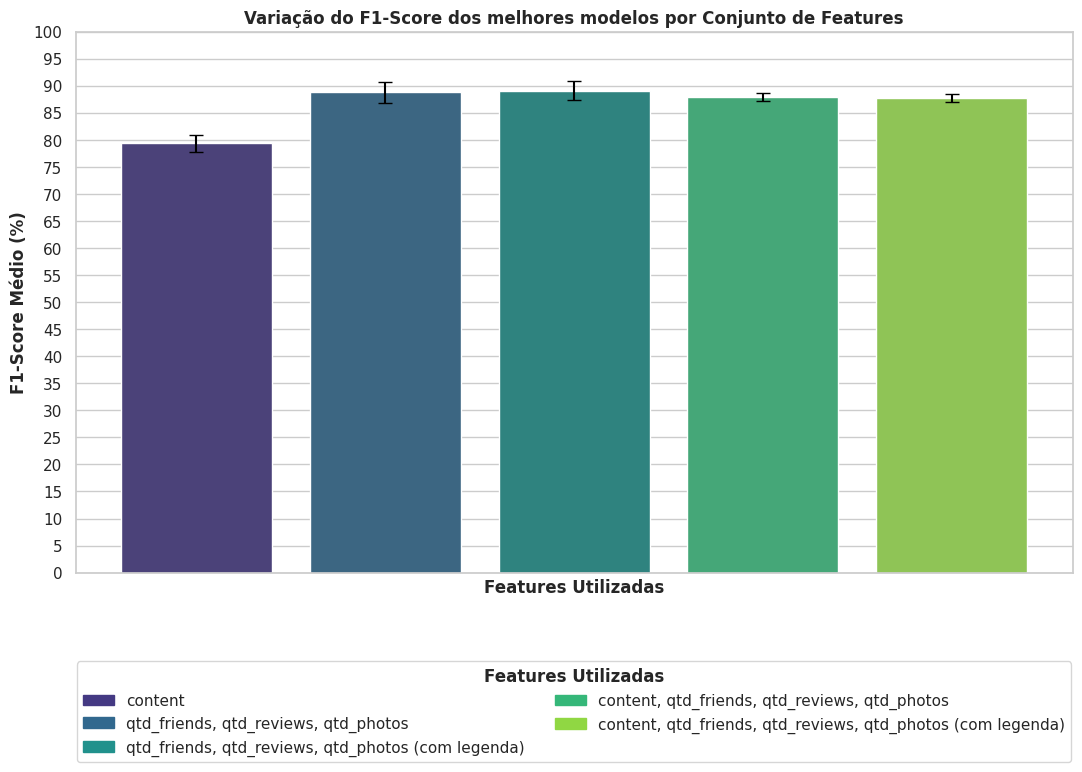

In [5]:
file_path = '/content/drive/My Drive/TCCII/_melhoresModelos.csv'
df = pd.read_csv(file_path)
df = df[df['model'] == 'bert-base-multilingual-uncased']

# Configurações gerais de estilo para gráficos
sns.set(style="whitegrid")

unique_features = df['features_used'].unique()
palette = sns.color_palette("viridis", len(unique_features))
color_mapping = dict(zip(unique_features, palette))

def percent_formatter(x, _):
    return f"{x * 100:.0f}"

# 3. Gráfico de Barras com Desvio Padrão para Variabilidade do F1-Score
plt.figure(figsize=(11.5, 8))
sns.barplot(data=df, x='features_used', y='f1_score_mean', hue='features_used', palette=color_mapping, ci=None)
plt.errorbar(df['features_used'], df['f1_score_mean'], yerr=(df['f1_score_max'] - df['f1_score_min']), fmt='none', capsize=5, color='black', label="Variação")

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().set_yticks([i / 100 for i in range(0, 105, 5)])

plt.xticks([])
plt.title("Variação do F1-Score dos melhores modelos por Conjunto de Features", fontweight='bold')
plt.ylabel("F1-Score Médio (%)", fontweight='bold')
plt.xlabel("Features Utilizadas", fontweight='bold')

legend_patches = [mpatches.Patch(color=color_mapping[feature], label=feature) for feature in unique_features]
plt.legend(
    handles=legend_patches,
    title='Features Utilizadas',
    title_fontproperties=font_manager.FontProperties(weight='bold'),
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.tight_layout()
plt.show()



In [6]:
file_path = '/content/drive/My Drive/TCCII/_melhoresModelos.csv'
df = pd.read_csv(file_path)
df_filtered = df #df[df['model'] == 'bert-base-multilingual-uncased']

df_latex = df_filtered[['model', 'features_used', 'learning_rate', 'weight_decay',
                        'accuracy_mean', 'precision_mean', 'recall_mean', 'f1_score_mean']]

df_latex.columns = ['Modelo Utilizado', 'Conjunto de Features', 'Learning Rate', 'Weight Decay',
                    'Acurácia', 'Precisão', 'Recall', 'F1-Score']

# Gerar o código LaTeX para a tabela
latex_code = """
\\begin{table*}
    \\caption{Comparação de Desempenho dos melhores modelos por Conjunto de Features e Hiperparâmetros}
    \\centering
    \\scriptsize
    \\renewcommand{\\arraystretch}{1.4}
    \\begin{tabular}{ p{0.19\\linewidth} p{0.35\\linewidth} p{0.06\\linewidth} p{0.06\\linewidth} p{0.05\\linewidth} p{0.05\\linewidth} p{0.05\\linewidth} p{0.06\\linewidth} }
        \\hline\\hline
        \\textbf{Modelo Utilizado} & \\textbf{Conjunto de Features} & \\textbf{Learning Rate} & \\textbf{Weight Decay} & \\textbf{Acurácia} & \\textbf{Precisão} & \\textbf{Recall} & \\textbf{F1-Score} \\\\
        \\hline
"""

# Adicionar cada linha dos dados do DataFrame ao código LaTeX
for _, row in df_latex.iterrows():
  row['Conjunto de Features'] = row['Conjunto de Features'].replace('_', '\\_')
  row['Modelo Utilizado'] = row['Modelo Utilizado'].replace('Word2Vec_KNN', 'Word2Vec com KNN')
  latex_code += f"        {row['Modelo Utilizado']} & {row['Conjunto de Features']} & {row['Learning Rate']} & {row['Weight Decay']} & {float(row['Acurácia']*100):.2f}\\% & {float(row['Precisão']*100):.2f}\\% & {float(row['Recall']*100):.2f}\\% & {float(row['F1-Score']*100):.2f}\\% \\\\ \n"

# Finalizar a tabela
latex_code += """
        \\hline\\hline
    \\end{tabular}
    \\label{tab:performance_comparison}
\\end{table*}
"""

# Exibir o código LaTeX
print(latex_code)


\begin{table*}
    \caption{Comparação de Desempenho dos melhores modelos por Conjunto de Features e Hiperparâmetros}
    \centering
    \scriptsize
    \renewcommand{\arraystretch}{1.4}
    \begin{tabular}{ p{0.19\linewidth} p{0.35\linewidth} p{0.06\linewidth} p{0.06\linewidth} p{0.05\linewidth} p{0.05\linewidth} p{0.05\linewidth} p{0.06\linewidth} }
        \hline\hline
        \textbf{Modelo Utilizado} & \textbf{Conjunto de Features} & \textbf{Learning Rate} & \textbf{Weight Decay} & \textbf{Acurácia} & \textbf{Precisão} & \textbf{Recall} & \textbf{F1-Score} \\
        \hline
        Word2Vec com KNN & content & - & - & 62.74\% & 66.08\% & 52.43\% & 58.43\% \\ 
        Word2Vec com KNN & qtd\_friends, qtd\_reviews, qtd\_photos & - & - & 87.12\% & 84.16\% & 91.48\% & 87.66\% \\ 
        Word2Vec com KNN & content, qtd\_friends, qtd\_reviews, qtd\_photos & - & - & 86.27\% & 81.64\% & 93.62\% & 87.21\% \\ 
        bert-base-multilingual-uncased & content & 1e-05 & 0.01 & 78.01\% & 74.

<ipython-input-7-2c6d3034972d>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df,


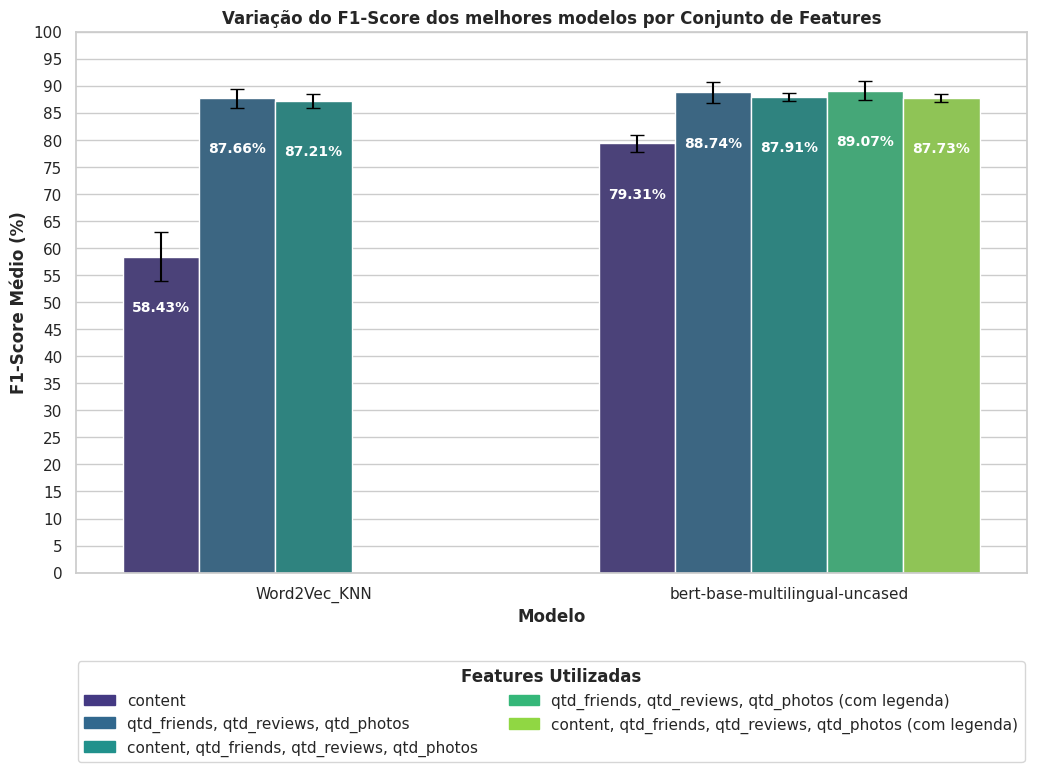

In [7]:
file_path = '/content/drive/My Drive/TCCII/_melhoresModelos.csv'
df = pd.read_csv(file_path)


# Configurações gerais de estilo para gráficos
sns.set(style="whitegrid")

unique_features = df['features_used'].unique()
palette = sns.color_palette("viridis", len(unique_features))
color_mapping = dict(zip(unique_features, palette))

def percent_formatter(x, _):
    return f"{x * 100:.0f}"

# Gráfico de Barras com agrupamento por 'model'
plt.figure(figsize=(11, 8))
ax = sns.barplot(data=df,
            x='model',
            y='f1_score_mean',
            hue='features_used',
            palette=color_mapping,
            ci=None
          )

# Adicionar valores percentuais acima das barras
for container in ax.containers:
    for bar in container:
        bar_height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Posição central da barra
            bar_height + -0.08,                 # Ligeiramente acima da barra
            f"{bar_height * 100:.2f}%",        # Valor em porcentagem
            ha='center', va='top', fontsize=10, fontweight='bold', color='white'
        )

# Adicionar barras de erro
for container, feature in zip(ax.containers, unique_features):
    feature_data = df[df['features_used'] == feature]
    for bar, (_, row) in zip(container, feature_data.iterrows()):
        bar_x = bar.get_x() + bar.get_width() / 2  # Posição central da barra
        plt.errorbar(
            x=bar_x,
            y=row['f1_score_mean'],
            yerr=(row['f1_score_max'] - row['f1_score_min']),
            fmt='none',
            capsize=5,
            color='black'
        )

# Configuração do eixo y
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().set_yticks([i / 100 for i in range(0, 105, 5)])

plt.title("Variação do F1-Score dos melhores modelos por Conjunto de Features", fontweight='bold')
plt.ylabel("F1-Score Médio (%)", fontweight='bold')
plt.xlabel("Modelo", fontweight='bold')

# Ajustar espaçamento dos grupos manualmente
ax.set_xlim(-0.5, len(df['model'].unique()) - 0.5)

# Adicionar legenda personalizada
legend_patches = [mpatches.Patch(color=color_mapping[feature], label=feature) for feature in unique_features]
plt.legend(
    handles=legend_patches,
    title='Features Utilizadas',
    title_fontproperties=font_manager.FontProperties(weight='bold'),
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.tight_layout()
plt.show()